# 本ノートブックの説明
今回のコンペのデータに関するEDAとConvNeXt Baseモデルを使用して画像特徴量を抽出し、faissを使用してコサイン類似度の高いもの画像を検索し、提出ファイルを作成する流れを紹介します。
過去の類似コンペとして[AI×商標：イメージサーチコンペティション（類似商標画像の検出）](https://competition.nishika.com/competitions/patent/summary)がございます。必要に応じてそちらもご確認ください。



## 注意事項
- インデックス作成処理については１時間ほど要します。

## 設定
- Google Driveのマウント
- 画像ファイルの展開
- 追加で必要なライブラリ(faiss-gpu, japanize_matplotlib, timm)のインストール

In [1]:
import collections
import math
import os
import random
import typing
from pathlib import Path

import faiss
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import timm
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from albumentations import Compose, Normalize, Resize
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from torch import nn
from torch.nn import CrossEntropyLoss, Parameter
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

from src.const import (
    DATA_ROOT,
    OUTPUT_ROOT,
    CITE_IMAGES_PATH,
    QUERY_IMAGES_PATH,
    TRAIN_CSV_WITH_IMG_PATH,
    CITE_CSV_WITH_IMG_PATH,
    TEST_CSV_WITH_IMG_PATH
)

In [2]:
DATA_DIR = DATA_ROOT
OUT_DIR = OUTPUT_ROOT / 'cpt_sake_tutorial'
FEATURES_DIR = OUT_DIR / 'features'
INDEX_DIR = OUT_DIR / 'index'
MODEL_DIR = OUT_DIR / "model"

CITE_IMG_DIR = CITE_IMAGES_PATH
QUERY_IMG_DIR = QUERY_IMAGES_PATH
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EXP_NAME = "cpt-sake-tutorial"


class CFG:
    img_size = 224
    model_name = "convnext_base"
    in_channels = 3
    embedding_dim = 128
    pretrained = True
    batch_size = 128
    n_workers = 0
    seed = 0

In [3]:
# 出力先ディレクトリを作成しておく
for out_dir in [FEATURES_DIR, INDEX_DIR, MODEL_DIR]:
    out_dir.mkdir(parents=True, exist_ok=True)

In [4]:
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(CFG.seed)

# データ

In [5]:
cite_filepath = DATA_DIR.joinpath("cite.csv")
train_filepath = DATA_DIR.joinpath("train.csv")
test_filepath = DATA_DIR.joinpath("test.csv")
sub_filepath = DATA_DIR.joinpath("sample_submission.csv")
df_cite = pd.read_csv(cite_filepath)
df_train = pd.read_csv(train_filepath)
df_test = pd.read_csv(test_filepath)
df_sub = pd.read_csv(sub_filepath)

## データの形式、概要確認

In [6]:
df_cite.shape

(109481, 2)

In [7]:
df_cite.head()

cite_gid  cite_filename
0  100000001  100000001.jpg
1  100000002  100000002.jpg
2  100000003  100000003.jpg
3  100000004  100000004.jpg
4  100000005  100000005.jpg

In [8]:
df_cite.isna().sum()

cite_gid         0
cite_filename    0
dtype: int64

In [9]:
df_train.shape

(108160, 4)

In [10]:
df_train.head()

gid       filename  brand_id meigara
0  200000001  200000001.jpg      3372      五橋
1  200000002  200000002.jpg      3751  庭のうぐいす
2  200000003  200000003.jpg      2856     笑四季
3  200000004  200000004.jpg      1527      鍋島
4  200000005  200000005.jpg      2676      仙禽

In [11]:
df_train.isna().sum()

gid         0
filename    0
brand_id    0
meigara     1
dtype: int64

In [12]:
df_train[df_train["meigara"].isna()]

gid       filename  brand_id meigara
9422  200009423  200009423.jpg      2775     NaN

In [13]:
df_test.shape

(2942, 2)

In [14]:
df_test.head()

gid       filename
0  200108161  200108161.jpg
1  200108162  200108162.jpg
2  200108163  200108163.jpg
3  200108164  200108164.jpg
4  200108165  200108165.jpg

In [15]:
df_test.isna().sum()

gid         0
filename    0
dtype: int64

## 提出ファイルの形式確認

In [16]:
df_sub.head()

gid                                           cite_gid
0  200108161  100000001 100000002 100000003 100000004 100000...
1  200108162  100000001 100000002 100000003 100000004 100000...
2  200108163  100000001 100000002 100000003 100000004 100000...
3  200108164  100000001 100000002 100000003 100000004 100000...
4  200108165  100000001 100000002 100000003 100000004 100000...

In [17]:
df_sub.dtypes

gid          int64
cite_gid    object
dtype: object

引用画像ID(gid)をスペースでつないだ文字列を予測結果とします。

In [18]:
pred_sample = df_sub["cite_gid"].values[0]
print(pred_sample)

100000001 100000002 100000003 100000004 100000005 100000006 100000007 100000008 100000009 100000010 100000011 100000012 100000013 100000014 100000015 100000016 100000017 100000018 100000019 100000020


## 画像ファイルのパス情報追加

In [19]:
cite_filenames = df_cite["cite_filename"].to_list()
df_cite["path"] = [str(CITE_IMG_DIR.joinpath(filename)) for filename in cite_filenames]
train_filenames = df_train["filename"].to_list()
df_train["path"] = [str(QUERY_IMG_DIR.joinpath(filename)) for filename in train_filenames]
test_filenames = df_test["filename"].to_list()
df_test["path"] = [str(QUERY_IMG_DIR.joinpath(filename)) for filename in test_filenames]
# csvに保存
df_cite.to_csv(CITE_CSV_WITH_IMG_PATH, index=False)
df_train.to_csv(TRAIN_CSV_WITH_IMG_PATH, index=False)
df_test.to_csv(TEST_CSV_WITH_IMG_PATH, index=False)

## 訓練データ brand_id, meigara

酒のブランドを識別するbrand_id

In [20]:
pd.value_counts(df_train['brand_id']).describe()

count    2515.000000
mean       43.005964
std       134.338212
min         1.000000
25%         2.000000
50%         7.000000
75%        27.000000
max      1726.000000
Name: count, dtype: float64

訓練データ内のbrand_idの種類数：2515


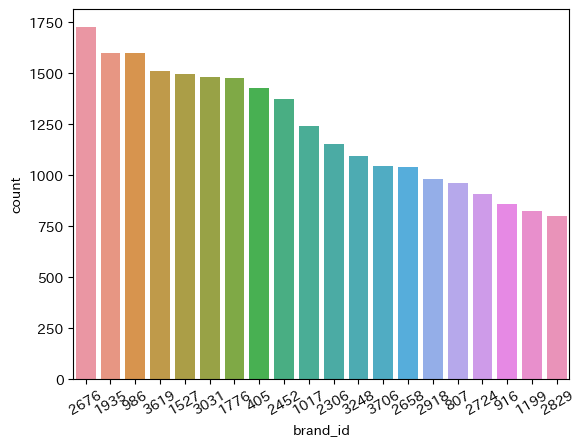

In [21]:
topn = 20
print("訓練データ内のbrand_idの種類数：{:4d}".format(df_train["brand_id"].nunique()))
ax = sns.countplot(x = df_train["brand_id"], order=pd.value_counts(df_train['brand_id']).iloc[:topn].index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.show()

In [12]:
pd.value_counts(df_train['meigara'])

meigara
仙禽         1726
写楽（寫樂）     1599
田酒         1597
風の森        1512
鍋島         1494
           ... 
北上川           1
小桜            1
空乃鶴           1
田舎あぜみち        1
33 MISA       1
Name: count, Length: 2498, dtype: int64

訓練データ内のmeigaraの種類数：2498


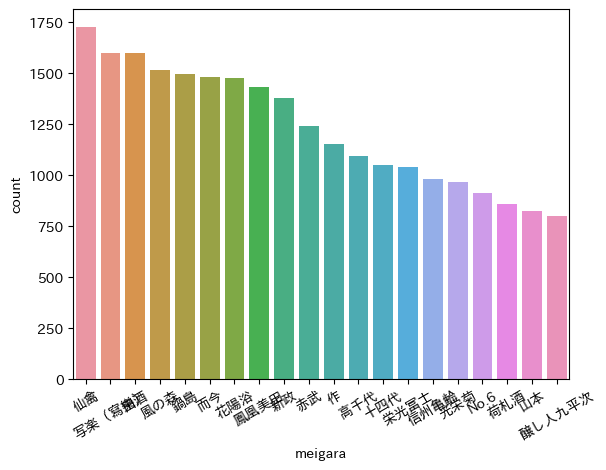

In [22]:
topn = 20
print("訓練データ内のmeigaraの種類数：{:4d}".format(df_train["meigara"].nunique()))
ax = sns.countplot(x = df_train["meigara"], order=pd.value_counts(df_train['meigara']).iloc[:topn].index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.show()

## meigaraが同じ画像サンプルを確認
- meigara：brand_idは多くの場合1:1ですが、１：Nの場合が一部存在し、別の酒蔵が同じ銘柄の商品を出す場合に別のブランドとして扱われております。
- 今回の画像検索の難しい点として、以下の点が確認できます。
 - お酒にフォーカスして撮影された写真もあれば、料理と一緒に撮影された写真もあります。
 - 同じブランドであってもお酒の容器のラベルレイアウトに複数の種類がある場合があります。


In [23]:
df_brand = df_train.groupby("meigara")["brand_id"].nunique().to_frame()
df_brand[df_brand["brand_id"] > 1]

brand_id
meigara             
BLACK JACK         2
亀の尾                2
初桜                 3
千代鶴                2
喜久水                2
喜平                 2
御代栄                2
男山                 2
白龍                 2
若駒                 2
菊勇                 2
豊祝                 2
金泉                 2
高砂                 2
黒龍                 2

BLACK JACK

In [24]:
df_train[df_train["meigara"] == "BLACK JACK"].head()

gid       filename  brand_id     meigara  \
1272   200001273  200001273.jpg      2912  BLACK JACK   
18854  200018855  200018855.jpg      2446  BLACK JACK   
33576  200033577  200033577.jpg      2912  BLACK JACK   
60805  200060806  200060806.jpg      2446  BLACK JACK   

                                        path  
1272   /work/data/query_images/200001273.jpg  
18854  /work/data/query_images/200018855.jpg  
33576  /work/data/query_images/200033577.jpg  
60805  /work/data/query_images/200060806.jpg

In [25]:
#@title
def show_same_meigara(meigara: str) -> None:
    image_paths = df_train.loc[df_train["meigara"] == meigara, "path"].to_numpy()
    brand_ids = df_train.loc[df_train["meigara"] == meigara, "brand_id"].to_numpy()
    col = 2
    # row = int(len(image_paths)/col)
    row = int(len(image_paths)/col)
    # サンプル数が奇数の場合、２列で表示できる分だけ表示する
    n_samples = row * col
    fig, axs = plt.subplots(row, col, figsize = (col * 5, row * 5))
    for i, path in enumerate(image_paths[:n_samples]):
        j = int(i / 2)
        k = i % 2
        image = Image.open(path)
        axs[j, k].imshow(image)
        title = f"brand_id: {str(brand_ids[i])}"
        axs[j, k].set_title(title)
        axs[j, k].axis('off')  # 軸を非表示にする
    plt.show()

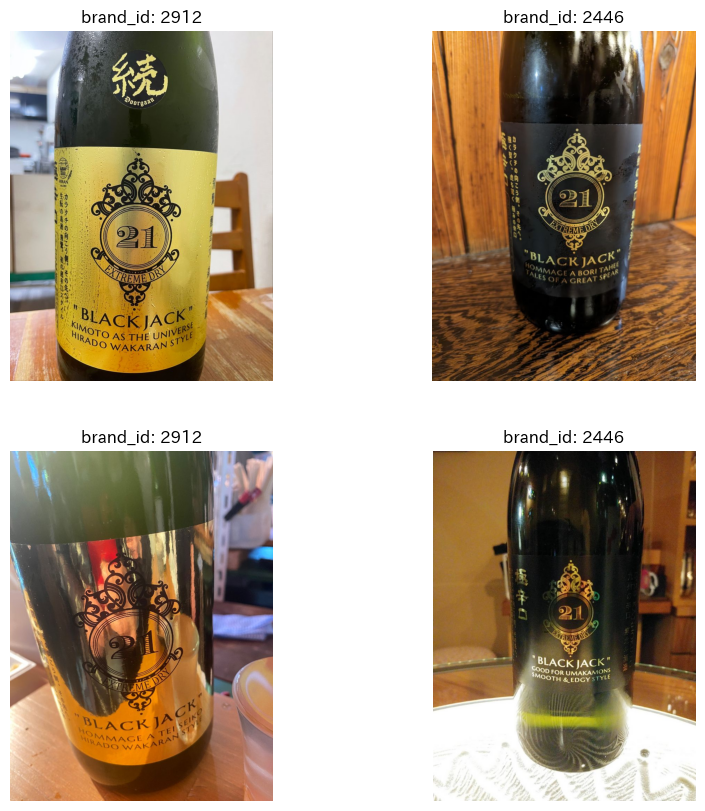

In [26]:
show_same_meigara(meigara = "BLACK JACK")

亀の尾

In [27]:
df_train[df_train["meigara"] == "亀の尾"].head()

gid       filename  brand_id meigara  \
14210  200014211  200014211.jpg       908     亀の尾   
23386  200023387  200023387.jpg      3338     亀の尾   
55107  200055108  200055108.jpg      3338     亀の尾   
87439  200087440  200087440.jpg      3338     亀の尾   
94871  200094872  200094872.jpg       908     亀の尾   

                                        path  
14210  /work/data/query_images/200014211.jpg  
23386  /work/data/query_images/200023387.jpg  
55107  /work/data/query_images/200055108.jpg  
87439  /work/data/query_images/200087440.jpg  
94871  /work/data/query_images/200094872.jpg

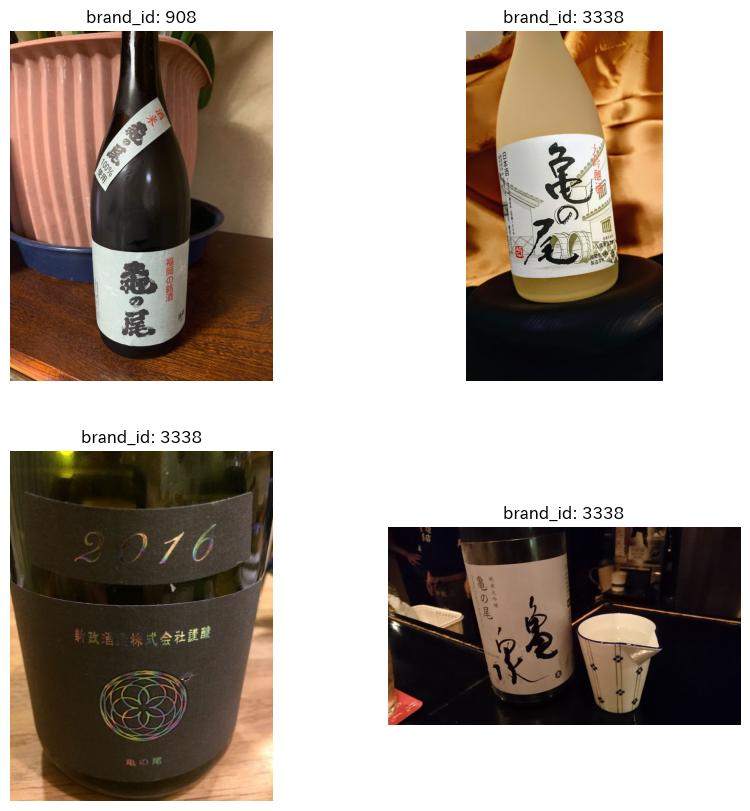

In [28]:
show_same_meigara(meigara = "亀の尾")

　初桜

In [29]:
df_train[df_train["meigara"] == "初桜"].head()

gid       filename  brand_id meigara  \
2194   200002195  200002195.jpg      2339      初桜   
3360   200003361  200003361.jpg      2149      初桜   
8604   200008605  200008605.jpg      2339      初桜   
15880  200015881  200015881.jpg      2339      初桜   
18925  200018926  200018926.jpg      2149      初桜   

                                        path  
2194   /work/data/query_images/200002195.jpg  
3360   /work/data/query_images/200003361.jpg  
8604   /work/data/query_images/200008605.jpg  
15880  /work/data/query_images/200015881.jpg  
18925  /work/data/query_images/200018926.jpg

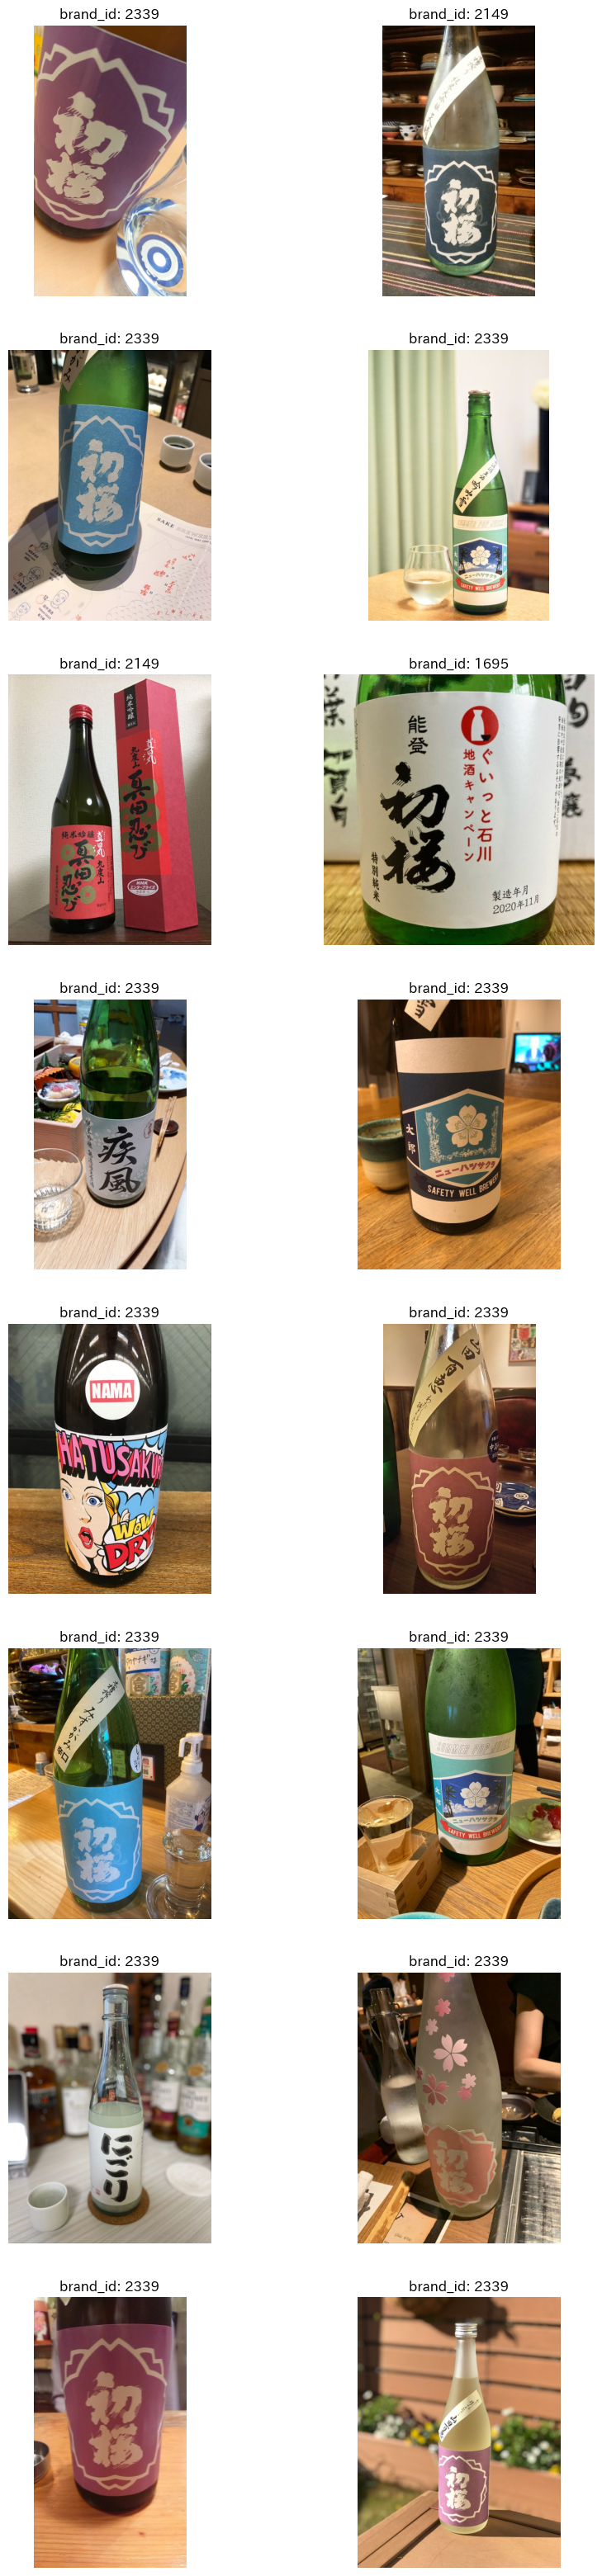

In [30]:
show_same_meigara(meigara = "初桜")

## データセット

In [24]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # RGB
IMAGENET_STD = [0.229, 0.224, 0.225]  # RGB

class SakeDataset(Dataset):
    def __init__(self, image_filepaths: list, labels: list = None,
                 transform: typing.Dict[str, typing.Any] =None) -> None:
        self.image_filepaths = image_filepaths
        self.labels = labels
        self.transform = transform

    def __len__(self) -> int:
        return len(self.image_filepaths)

    def __getitem__(self, idx: int) -> typing.Tuple[torch.tensor, torch.tensor]:
        item = dict()
        image_filepath = self.image_filepaths[idx]
        image = self.__read_image(image_filepath)
        if self.transform is not None:
            image = self.transform(image = image)["image"]
            item["image"] = image

        if self.labels is not None:
            label = self.labels[idx]
            label = torch.tensor(label, dtype = torch.long)
            item["label"] = label
        return item

    def __read_image(self, path: str) -> None:
        with open(path, 'rb') as f:
            image = Image.open(f)
            image_rgb = image.convert('RGB')
        image = np.array(image_rgb)
        return image

def get_transforms(img_size: int = 224) -> torch.tensor:
    return Compose(
        [
            Resize(img_size, img_size),
            Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
            ToTensorV2()
        ]
    )

# ConvNeXt Baseモデルの画像特徴量で検索

In [25]:
class SakeNet(nn.Module):
    def __init__(
        self,
        cfg
    ):
        super().__init__()
        self.cfg = cfg
        if hasattr(timm.models, cfg.model_name):
            base_model = timm.create_model(
                cfg.model_name, num_classes=0, pretrained=cfg.pretrained, in_chans=cfg.in_channels)
            in_features = base_model.num_features
            self.backbone = base_model
            print("load imagenet model_name:", cfg.model_name)
            print("load imagenet pretrained:", cfg.pretrained)
        else:
            raise NotImplementedError
        self.in_features = in_features
        self.fc = nn.Linear(self.in_features, cfg.embedding_dim)

    def get_embedding(self, image: torch.tensor) -> torch.tensor:
        output = self.backbone(image)
        output = self.fc(output)
        return output

In [26]:
model = SakeNet(cfg = CFG)
model = model.to(DEVICE)
model_path = MODEL_DIR.joinpath(f"{EXP_NAME}.pth")
torch.save(model.state_dict(), model_path)

load imagenet model_name: convnext_base
load imagenet pretrained: True


## インデックス作成

In [27]:
def infer(data_loader: DataLoader, model: nn.Module) -> np.array:
    stream = tqdm(data_loader)
    model.eval()
    embedding = []
    for batch in stream:
        images = batch["image"].to(DEVICE, non_blocking = True).float()
        # targets = batch["target"].to(DEVICE, non_blocking = True).float().view(-1, 1)
        with torch.set_grad_enabled(mode = False):
            output = model.get_embedding(images)
            embedding.append(output.detach().cpu().numpy())
    embedding = np.concatenate(embedding)
    return embedding


In [28]:
cite_dataset = SakeDataset(
  image_filepaths = df_cite["path"].to_list(),
  transform = get_transforms()
)
cite_loader = DataLoader(
  cite_dataset,
  batch_size = CFG.batch_size,
  shuffle = False,
  num_workers = CFG.n_workers,
  pin_memory = True
)
model = SakeNet(cfg = CFG)
model = model.to(DEVICE)
model.load_state_dict(torch.load(model_path))
cite_embedding = infer(cite_loader, model)

load imagenet model_name: convnext_base
load imagenet pretrained: True


  0%|          | 0/856 [00:00<?, ?it/s]

In [29]:
np.save(FEATURES_DIR.joinpath(f"cite_embedding_{EXP_NAME}.npy"), cite_embedding)

In [30]:
cite_embedding = np.load(FEATURES_DIR.joinpath(f"cite_embedding_{EXP_NAME}.npy"))
cite_embedding.shape

(109481, 128)

In [31]:
class FaissKNeighbors:
    def __init__(self, model_name: str, index_name: str, k: int = 10) -> None:
        self.index = None
        self.d = None
        self.k = k
        self.model_name = model_name
        self.index_name = str(INDEX_DIR.joinpath(f"{index_name}.index"))

    def fit(self, X: np.array) -> None:
        X = X.copy(order="C")
        self.d = X.shape[1]
        # distance: cosine similarity
        self.index = faiss.IndexFlatIP(self.d)
        self.index.add(X.astype(np.float32))

    def save_index(self) -> None:
        faiss.write_index(self.index, self.index_name)
        print(f"{self.index_name} saved.")

    def read_index(self) -> None:
        self.index = faiss.read_index(self.index_name)
        self.d = self.index.d
        print(f"{self.index_name} read.")

    def predict(self, X: np.array) -> typing.Tuple:
        X = X.copy(order="C")
        X = np.reshape(X, (-1, self.d))
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        if X.shape[0] == 1:
            return distances[0], indices[0]
        else:
            return distances, indices

In [32]:
knn = FaissKNeighbors(model_name =CFG.model_name, index_name = EXP_NAME, k = 20)
knn.fit(cite_embedding)
knn.save_index()

/work/output/cpt_sake_tutorial/index/cpt-sake-tutorial.index saved.


In [33]:
df_cite.head()

cite_gid  cite_filename                                  path
0  100000001  100000001.jpg  /work/data/cite_images/100000001.jpg
1  100000002  100000002.jpg  /work/data/cite_images/100000002.jpg
2  100000003  100000003.jpg  /work/data/cite_images/100000003.jpg
3  100000004  100000004.jpg  /work/data/cite_images/100000004.jpg
4  100000005  100000005.jpg  /work/data/cite_images/100000005.jpg

In [34]:
idx2cite_gid = dict(zip(df_cite.index, df_cite["cite_gid"]))

## クエリ画像の検索

In [35]:
test_dataset = SakeDataset(
  image_filepaths = df_test["path"].to_list(),
  transform = get_transforms()
)
test_loader = DataLoader(
  test_dataset,
  batch_size = CFG.batch_size,
  shuffle = False,
  num_workers = CFG.n_workers,
  pin_memory = True
)

query_embedding = infer(test_loader, model)
np.save(FEATURES_DIR.joinpath(f"query_embedding_{EXP_NAME}.npy"), query_embedding)

  0%|          | 0/23 [00:00<?, ?it/s]

In [36]:
query_embedding = np.load(FEATURES_DIR.joinpath(f"query_embedding_{EXP_NAME}.npy"))
query_embedding.shape

(2942, 128)

In [37]:
cite_gids = []
for _query_embeding in tqdm(query_embedding):
    distance, pred = knn.predict(_query_embeding)
    _cite_gids = [str(idx2cite_gid[p]) for p in pred]
    cite_gids.append(" ".join(_cite_gids))
df_test["cite_gid"] = cite_gids
df_test[["gid", "cite_gid"]].to_csv(OUT_DIR.joinpath(f"submission_{EXP_NAME}.csv"), index = False)

  0%|          | 0/2942 [00:00<?, ?it/s]

In [38]:
#@title
def view_result_bygid(df_test: pd.DataFrame, gid: int) -> None:
    pred_gids = df_test.loc[df_test["gid"] == gid, "cite_gid"].values[0]
    pred_gids = pred_gids.split()

    query_path = df_test.loc[df_test["gid"] == gid, "path"].values[0]
    paths = []
    paths.append(query_path)
    cite_paths = [str(CITE_IMG_DIR.joinpath(path + ".jpg")) for path in pred_gids]
    paths.extend(cite_paths)

    figs, axs = plt.subplots(nrows = 7, ncols = 3, figsize = (10,20))
    for i, path in enumerate(paths):
        img = Image.open(path)
        i_row = int(i / 3)
        i_col = i % 3
        axs[i_row, i_col].imshow(img)
        gid = path.split("/")[-1].replace(".jpg", "")
        if i == 0:
            title = f"query data gid:{gid}"
            color = "red"
        else:
            title = f"rank: {i}, cite_gid:{gid}"
            color = "black"

        axs[i_row, i_col].set_title(title, color = color)
        axs[i_row, i_col].grid(False)
        axs[i_row, i_col].axis("off")
    plt.show()

## 検索結果の確認

In [39]:
df_test.head()

gid       filename                                   path  \
0  200108161  200108161.jpg  /work/data/query_images/200108161.jpg   
1  200108162  200108162.jpg  /work/data/query_images/200108162.jpg   
2  200108163  200108163.jpg  /work/data/query_images/200108163.jpg   
3  200108164  200108164.jpg  /work/data/query_images/200108164.jpg   
4  200108165  200108165.jpg  /work/data/query_images/200108165.jpg   

                                            cite_gid  
0  100071725 100092725 100025175 100057861 100087...  
1  100103726 100104659 100015484 100004873 100102...  
2  100025379 100045917 100097204 100075867 100033...  
3  100031285 100035860 100043139 100058886 100022...  
4  100038021 100036931 100006007 100031023 100096...

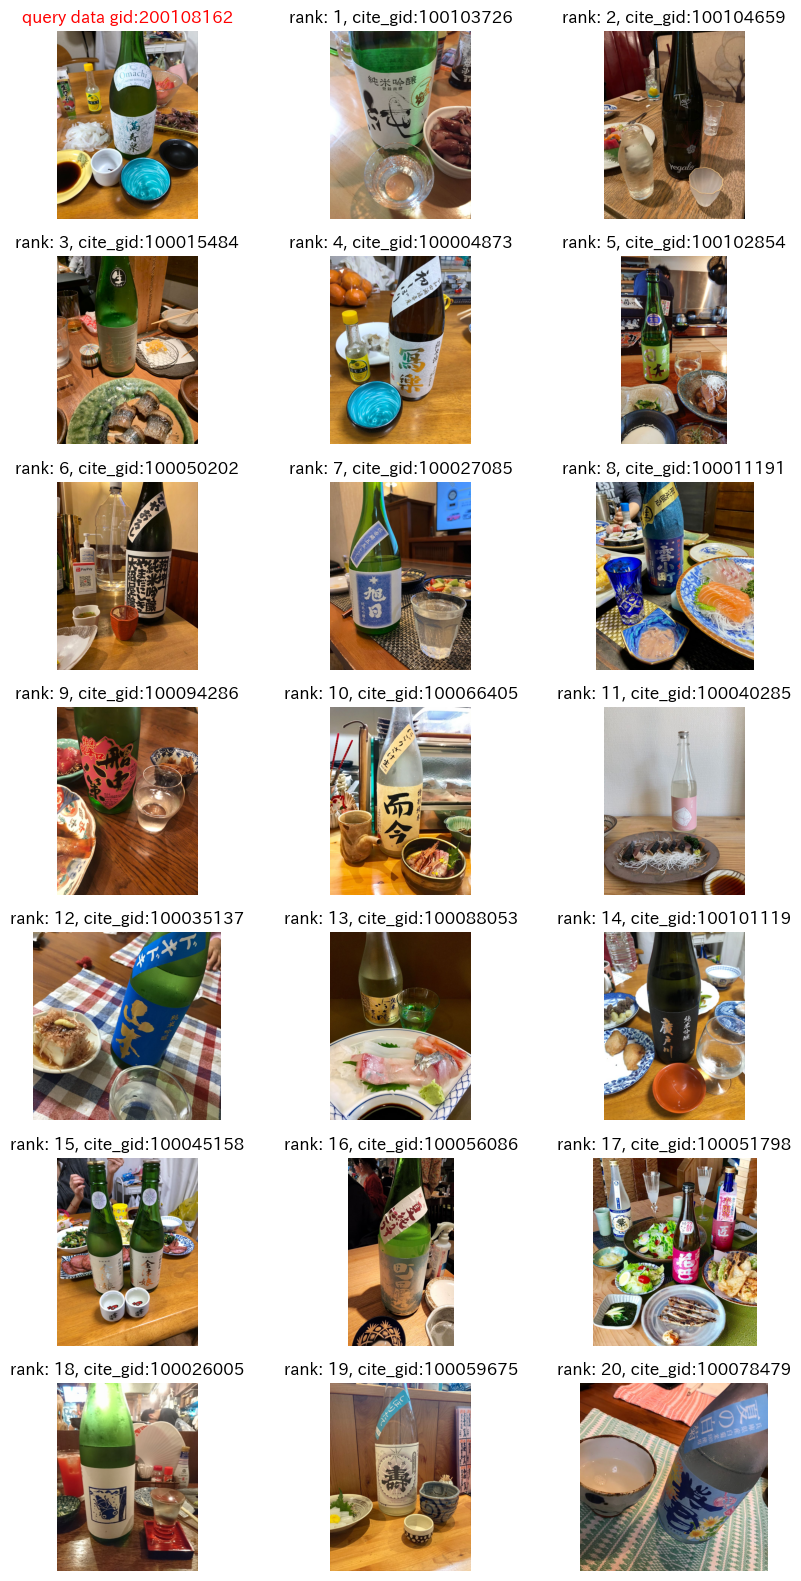

In [40]:
view_result_bygid(df_test, gid = 200108162)

# EOF